In [3]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
!unzip '/content/drive/MyDrive/Study/AICE Pro./image/flower_photos.zip'

In [47]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = '/content/train'
data_dir = pathlib.Path(data_dir)

In [49]:
!ls -ltrh {data_dir}

total 148K
drwxr-xr-x 2 root root 20K Oct 25  2025 daisy
drwxr-xr-x 2 root root 36K Oct 25  2025 dandelion
drwxr-xr-x 2 root root 20K Oct 25  2025 roses
drwxr-xr-x 2 root root 36K Oct 25  2025 sunflowers
drwxr-xr-x 2 root root 36K Oct 25  2025 tulips


In [50]:
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 5

In [52]:
img_path ='/content/train'

In [53]:
# image_dataset_from_directory
# image one-hotencoding labeling, batch, shuffle

# Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # size
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      #  size
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 3467 files belonging to 5 classes.
Using 2774 files for training.
Found 3467 files belonging to 5 classes.
Using 693 files for validation.


In [54]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [72]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [73]:
test_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [55]:
base_model.trainable = False

In [56]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D
#이미지 갯수 5개
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
learning_rate = 0.0003
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [59]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [60]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [61]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=10,
    callbacks=[es, checkpoint]
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4164 - loss: 1.4243
Epoch 1: val_loss improved from inf to 0.75063, saving model to my_checkpoint.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.4181 - loss: 1.4211 - val_accuracy: 0.7576 - val_loss: 0.7506
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7937 - loss: 0.6616
Epoch 2: val_loss improved from 0.75063 to 0.56270, saving model to my_checkpoint.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7938 - loss: 0.6611 - val_accuracy: 0.8196 - val_loss: 0.5627
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8469 - loss: 0.4889
Epoch 3: val_loss improved from 0.56270 to 0.47502, saving model to my_checkpoint.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8469 - loss: 0.4888 - val_accuracy: 0.8413 - val_loss: 0.4750
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8729 - loss: 0.4163
Epoch 4: val_loss improved from 0.47502 to 0.43116, saving m

In [62]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

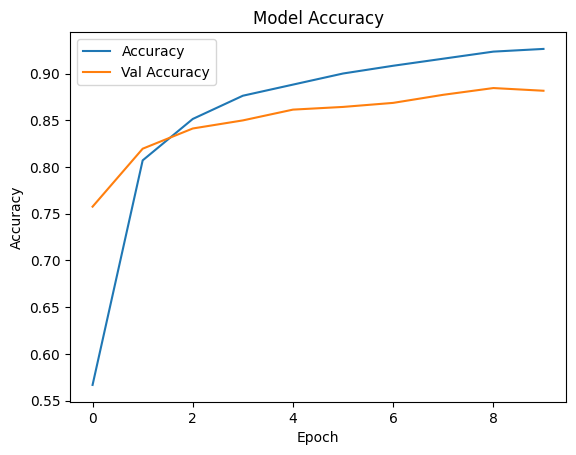

In [63]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [68]:

import os
file_path = '/content/test'
file_list = os.listdir(file_path)

In [75]:
# train_ds 로부터 자동 생성
label_dict = {i: name for i, name in enumerate(train_ds.class_names)}
label_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [77]:
results = []

for item in file_list:
    img_path = os.path.join(file_path, item)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = x / 255.0

    preds = model.predict(x)
    pred_class = np.argmax(preds)
    class_name = label_dict[pred_class]

    results.append({
        "filename": item,
        "pred_class": class_name,
        "pred_probs": preds.tolist()[0]
    })

for r in results:
    print(r["filename"], "→", r["pred_class"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━

In [78]:
results

[{'filename': 'sunflowers (678).jpg',
  'pred_class': 'sunflowers',
  'pred_probs': [0.15569092333316803,
   0.1781798154115677,
   0.019070066511631012,
   0.6193158626556396,
   0.027743330225348473]},
 {'filename': 'sunflowers (659).jpg',
  'pred_class': 'dandelion',
  'pred_probs': [0.06695950776338577,
   0.6613213419914246,
   0.0009526578360237181,
   0.26915591955184937,
   0.0016105303075164557]},
 {'filename': 'roses (627).jpg',
  'pred_class': 'roses',
  'pred_probs': [3.2519390515517443e-05,
   6.135322792033548e-07,
   0.9986222982406616,
   0.00012847041944041848,
   0.0012162106577306986]},
 {'filename': 'roses (621).jpg',
  'pred_class': 'roses',
  'pred_probs': [0.006066939327865839,
   0.08224017173051834,
   0.6786843538284302,
   0.0035339058376848698,
   0.22947467863559723]},
 {'filename': 'daisy (603).jpg',
  'pred_class': 'daisy',
  'pred_probs': [0.9642252326011658,
   0.0230394434183836,
   0.0006588459946215153,
   0.00990233663469553,
   0.002174006076529622

In [81]:
import pandas as pd
df_result = pd.DataFrame(results)
df_result

,filename,pred_class,pred_probs
0,sunflowers (678).jpg,sunflowers,"[0.15569092333316803, 0.1781798154115677, 0.01..."
1,sunflowers (659).jpg,dandelion,"[0.06695950776338577, 0.6613213419914246, 0.00..."
2,roses (627).jpg,roses,"[3.2519390515517443e-05, 6.135322792033548e-07..."
3,roses (621).jpg,roses,"[0.006066939327865839, 0.08224017173051834, 0...."
4,daisy (603).jpg,daisy,"[0.9642252326011658, 0.0230394434183836, 0.000..."
...,...,...,...
198,sunflowers (657).jpg,dandelion,"[0.0858154445886612, 0.7044651508331299, 0.001..."
199,tulips (790).jpg,tulips,"[0.0013741913717240095, 0.00034984981175512075..."
200,daisy (613).jpg,daisy,"[0.7851174473762512, 0.006881880573928356, 0.0..."
201,roses (632).jpg,roses,"[0.007197823375463486, 0.00731563288718462, 0...."


In [104]:
df_result.apply(lambda row: row['pred_class'] in row['filename'], axis=1).sum()

np.int64(186)